# Applied Data Science Capstone
### A Study of Factors that Affect COVID-19 Infections


## 1. Introduction

Coronavirus disease 2019 (COVID-19) is an infectious disease caused by the severe acute respiratory syndrome coronavirus (SARS-CoV-2) that outbroke in December 2019. As of April 27th, 2020, more than 3 million people around the world were infected with coronavirus, among which more than 1 million people are from the United States. So far, the total number of death toll around the world has exceeded 200,000. Therefore, it is of importance for the public to understand what factors are related to the number of COVID-19 cases, so that effective measures can be taken to reduce the risk of exposure to coronavirus.

The targeted audience of this work is the general public who are interested in learning the relationship between daily activities and COVID-19 infections. This work aims to answer if different **_venue types_** in the neighborhoods is related to the number of COVID-19 cases. New York City, the epicenter of the coronavirus outbreak in the US, will be studied as an example. Besides **_venue types_** in in New York City neighborhoods, **_population_** and **_population density_** will also be explored as factors for COVID-19 infections on the county level across New York State. 

## 2. Data

The data used for this work includes the following:

•	County information in New York State, scraped from Wikipedia. Population, population density and FIPS code data will be extracted from this source.

•	COVID-19 statistics for New York State, obtained from the New York State government website. 

•	COVID-19 statistics for New York City, obtained from NYC Department of Health and Mental Hygiene.

•	County and zip code coordinate data, obtained from github open sources.

•	Venue information in New York City, obtained using Foursquare API.


In [2]:
!pip install --upgrade pip
!pip install geopy
!pip install geocoder
!pip install folium
!pip install wget

Requirement already up-to-date: pip in ./anaconda3/lib/python3.6/site-packages (20.1)


Import all necessary packages 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
import folium
from geopy.geocoders import Nominatim
import seaborn as sns
from scipy import stats
try:
    from bs4 import BeautifulSoup
except ImportError:
    from BeautifulSoup import BeautifulSoup
from datetime import datetime,timedelta
import wget
from folium.plugins import HeatMap
from sodapy import Socrata


### 2.1 Scrape County Data from Wikipedia

Use BeautifulSoup to obtain **_FIPS codes_**, **_population_**, **_population density_** and **_area_** data for each county in New York State from Wikipedia

In [4]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_counties_in_New_York')

In [5]:
soup = BeautifulSoup(url.text,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})
headers = table.find_all('th')
headers = headers[-62:]

counties = []
for header in headers:
    a = header.find('a')
    title = a.get('title')
    counties.append(title)
    
rows = table.find_all('tr')

fips = []
density = []
pop = []
area = []
for row in rows[1:]:
    data = row.find_all('td')
    
    fip = data[0].find('a')
    den = data[-4]
    pop_ = data[-3].find('span')
    ar = data[-2].find('span')
    
    fip = int('36'+str(fip)[-7:-4])
    den = float(str(data[-4])[4:-7].replace(',',''))
    pop_ = float(str(pop_)[45:-7].replace(',',''))
    ar = float(str(ar)[45:-7].replace(',',''))
    
    fips.append(fip)
    density.append(den)
    pop.append(pop_)
    area.append(ar)


Convert county data to a dataframe

In [6]:
counties = pd.DataFrame(counties)
fips = pd.DataFrame(fips)
density = pd.DataFrame(density)
pop = pd.DataFrame(pop)
area = pd.DataFrame(area)

countydata = pd.concat([counties,fips,density,pop,area], axis=1)
countydata.columns = ['county','fips','density','population','area']
countydata.county = countydata.county.str.replace(' County','')
countydata.county = countydata.county.str.replace(', New York','')
countydata.head()

,county,fips,density,population,area
0,Albany,36001,570.7,304204.0,533.00
1,Allegany,36003,47.3,48946.0,1034.00
2,Bronx,36005,24118.2,1385108.0,57.43
3,Broome,36007,280.5,200600.0,715.00
4,Cattaraugus,36009,61.3,80317.0,1310.00


### 2.2 Obtain COVID-19 Data from NYS Government Website

Get today's date to obtain the latest data

In [7]:
newdate = str(datetime.date(datetime.now())-timedelta(days=1))
newdate

'2020-04-27'

Import COVID-19 data from NYS Government Website

In [8]:
req1 = requests.get('https://health.data.ny.gov/resource/xdss-u53e.json?test_date={}T00:00:00.000'.format(newdate))

In [9]:
nydatanew = json_normalize(req1.json())

Combine the county data and COVID-19 data into one dataframe

In [10]:
nydatanew['fips'] = ''
nydatanew['density'] = ''
nydatanew['population'] = ''
nydatanew['area'] = ''
for i in nydatanew.index:
    for n in countydata.index:
        if nydatanew['county'].iloc[i]==countydata['county'].iloc[n]:
            nydatanew['fips'][i]=countydata['fips'][n]
            nydatanew['density'][i]=countydata['density'][n]
            nydatanew['population'][i]=countydata['population'][n]
            nydatanew['area'][i]=countydata['area'][n]
        

Check data types and convert numeric data to the correct format

In [11]:
nydatanew.dtypes

county                            object
cumulative_number_of_positives    object
cumulative_number_of_tests        object
new_positives                     object
test_date                         object
total_number_of_tests             object
fips                              object
density                           object
population                        object
area                              object
dtype: object

In [12]:
nydatanew[['cumulative_number_of_positives', 'cumulative_number_of_tests', 'new_positives', 'total_number_of_tests','density','population','area','fips']] = nydatanew[['cumulative_number_of_positives', 'cumulative_number_of_tests', 'new_positives', 'total_number_of_tests','density','population','area','fips']].astype('int64')
nydatanew.head()

,county,cumulative_number_of_positives,cumulative_number_of_tests,new_positives,test_date,total_number_of_tests,fips,density,population,area
0,Albany,1009,9520,30,2020-04-27T00:00:00.000,197,36001,570,304204,533
1,Allegany,35,499,0,2020-04-27T00:00:00.000,14,36003,47,48946,1034
2,Bronx,35994,84316,438,2020-04-27T00:00:00.000,2107,36005,24118,1385108,57
3,Broome,266,2160,5,2020-04-27T00:00:00.000,60,36007,280,200600,715
4,Cattaraugus,45,748,0,2020-04-27T00:00:00.000,15,36009,61,80317,1310


In [13]:
nydatanew.dtypes

county                            object
cumulative_number_of_positives     int64
cumulative_number_of_tests         int64
new_positives                      int64
test_date                         object
total_number_of_tests              int64
fips                               int64
density                            int64
population                         int64
area                               int64
dtype: object

## 3. Data Exploration, Mapping and Modeling

### 3.1 Explore the Relationship within COVID-19 Cases, Tests ,Population and Population Density

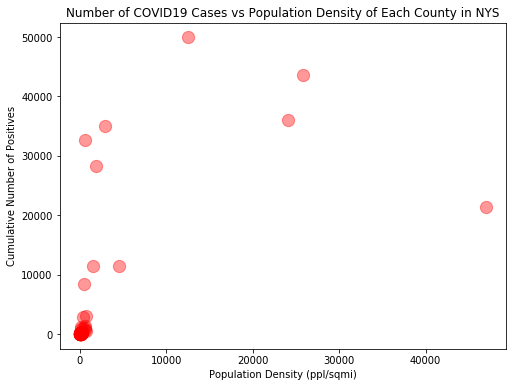

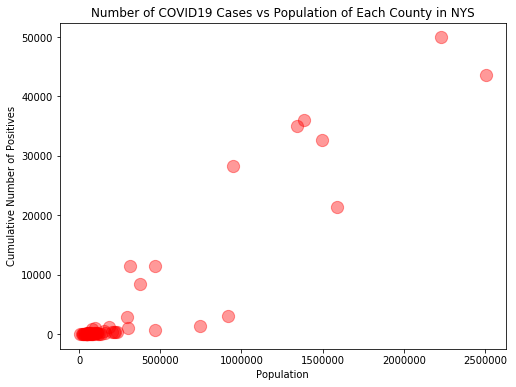

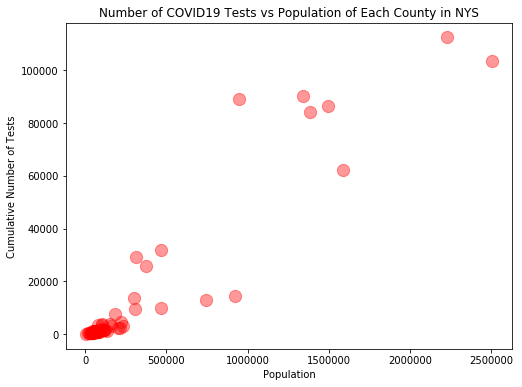

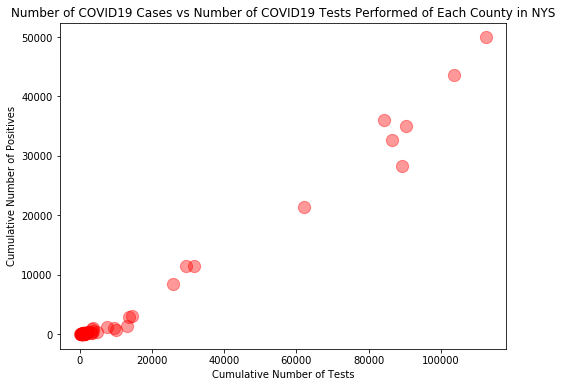

In [14]:
ax0 = nydatanew.plot(kind='scatter',
                 x='density',
                 y='cumulative_number_of_positives',
                 figsize=(8,6),
                 alpha=0.4,
                 color="r",
                 s=150)
ax0.set_title('Number of COVID19 Cases vs Population Density of Each County in NYS')
ax0.set_ylabel('Cumulative Number of Positives')
ax0.set_xlabel('Population Density (ppl/sqmi)')

ax1 = nydatanew.plot(kind='scatter',
                 x='population',
                 y='cumulative_number_of_positives',
                 figsize=(8,6),
                 alpha=0.4,
                 color="r",
                 s=150)
ax1.set_title('Number of COVID19 Cases vs Population of Each County in NYS')
ax1.set_ylabel('Cumulative Number of Positives')
ax1.set_xlabel('Population')

ax2 = nydatanew.plot(kind='scatter',
                 x='population',
                 y='cumulative_number_of_tests',
                 figsize=(8,6),
                 alpha=0.4,
                 color="r",
                 s=150)
ax2.set_title('Number of COVID19 Tests vs Population of Each County in NYS')
ax2.set_ylabel('Cumulative Number of Tests')
ax2.set_xlabel('Population')

ax3 = nydatanew.plot(kind='scatter',
                 x='cumulative_number_of_tests',
                 y='cumulative_number_of_positives',
                 figsize=(8,6),
                 alpha=0.4,
                 color="r",
                 s=150)
ax3.set_title('Number of COVID19 Cases vs Number of COVID19 Tests Performed of Each County in NYS')
ax3.set_ylabel('Cumulative Number of Positives')
ax3.set_xlabel('Cumulative Number of Tests')

plt.show()

### 3.2 Map the COVID-19 Data

Note: Since geolocator has returned wrong coordinate information for multiple locations, location files are used to retrieve coordinate data instead.

In [15]:
coord = pd.read_csv('https://raw.githubusercontent.com/btskinner/spatial/master/data/county_centers.csv')
coord.head()

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,1001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,1003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,1005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,1007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,1009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243


Look up coordinate data for each FIP code and add coordinate data to COVID-19 data frame

In [16]:
nydatanew['lat']=''
nydatanew['long']=''

for i in nydatanew.index:
    for n in coord.index:
        if nydatanew['fips'].iloc[i]==coord['fips'].iloc[n]:
            nydatanew['lat'][i]=coord['pclat10'][n]
            nydatanew['long'][i]=coord['pclon10'][n]


/Users/linxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/linxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
nydatanew.head()

,county,cumulative_number_of_positives,cumulative_number_of_tests,new_positives,test_date,total_number_of_tests,fips,density,population,area,lat,long
0,Albany,1009,9520,30,2020-04-27T00:00:00.000,197,36001,570,304204,533,42.679,-73.813
1,Allegany,35,499,0,2020-04-27T00:00:00.000,14,36003,47,48946,1034,42.2282,-78.0193
2,Bronx,35994,84316,438,2020-04-27T00:00:00.000,2107,36005,24118,1385108,57,40.8494,-73.8824
3,Broome,266,2160,5,2020-04-27T00:00:00.000,60,36007,280,200600,715,42.1213,-75.9342
4,Cattaraugus,45,748,0,2020-04-27T00:00:00.000,15,36009,61,80317,1310,42.2243,-78.6077


Sort data by cumulative number of positive cases in descending order

In [18]:
nydatanew = nydatanew.sort_values(by=['cumulative_number_of_positives'], ascending=False)
nydatanew.head()

,county,cumulative_number_of_positives,cumulative_number_of_tests,new_positives,test_date,total_number_of_tests,fips,density,population,area,lat,long
40,Queens,49929,112427,530,2020-04-27T00:00:00.000,2628,36081,12512,2230722,178,40.7213,-73.8335
23,Kings,43587,103673,573,2020-04-27T00:00:00.000,2940,36047,25848,2504700,96,40.6505,-73.9548
2,Bronx,35994,84316,438,2020-04-27T00:00:00.000,2107,36005,24118,1385108,57,40.8494,-73.8824
29,Nassau,35085,90267,220,2020-04-27T00:00:00.000,1499,36059,2957,1339532,453,40.7166,-73.6022
51,Suffolk,32724,86499,254,2020-04-27T00:00:00.000,1429,36103,629,1493350,2373,40.8219,-73.1138


Get the geojson data for New York State

In [19]:
wget.download('https://cugir.library.cornell.edu/download/file/cugir-007865-geojson.json')

'cugir-007865-geojson (5).json'

In [20]:
ny_geo = r'cugir-007865-geojson.json'
ny_geo

'cugir-007865-geojson.json'

Locate New York State

In [21]:
address = 'New York State, US'

In [22]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinates of New York State, US are 43.1561681, -75.8449946.


Visualize both population density and number of COVID-19 cases on the map

In [179]:
map_ny1 = folium.Map(location=[latitude, longitude], zoom_start=6)
map_ny1.choropleth(
    geo_data=ny_geo,
    data=nydatanew,
    columns=['county', 'density'],
    key_on='feature.properties.name',
    fill_color='Purples', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='New York State Population Density'
)

for lat, lng, cases in zip(nydatanew['lat'], nydatanew['long'], nydatanew['cumulative_number_of_positives']):
    label = '{}'.format(cases)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=cases.astype('float')/1000,
        popup=label,
        color='red',
        weight=1,
        fill=True,
        fill_color='red',
        fill_opacity=0.2,
        parse_html=False).add_to(map_ny1) 

    #threshold_scale=[0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000],
map_ny1

/Users/linxi/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 3.3 Study New York City in More Detail

Get the COVID-19 data by zip code in New York

In [24]:
nycovzc = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests-by-zcta.csv')
nycovzc.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,NaN,1443,1710,84.39
1,10001.0,300,759,39.53
2,10002.0,828,1746,47.42
3,10003.0,381,1037,36.74
4,10004.0,26,79,32.91


In [25]:
nycovzc = nycovzc.iloc[1:].reset_index()

Get the coordinate data for each zip code

In [26]:
#Data from https://public.opendatasoft.com
zcloc = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
zcloc.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


Only keep the zip code data that is between 10000 and 12000 for faster processing

In [27]:
zclocny = zcloc[~(zcloc['ZIP'] <= 10000)]  
zclocny = zclocny[~(zclocny['ZIP'] >= 12000)].reset_index()
zclocny = zclocny.drop('index', axis=1)
zclocny.head()

,ZIP,LAT,LNG
0,10001,40.750633,-73.997177
1,10002,40.715775,-73.986212
2,10003,40.731829,-73.989181
3,10004,40.688630,-74.018244
4,10005,40.706027,-74.008835


Check data format in zip code data

In [28]:
zcloc.dtypes

ZIP      int64
LAT    float64
LNG    float64
dtype: object

Match the zip code data format in the COVID-19 data to the zip code data format in coordinate data

In [29]:
nycovzc['MODZCTA'] = nycovzc['MODZCTA'].astype('int64')

Add coordinate data to the COVID-19 data frame

In [30]:
nycovzc['lat'] = ''
nycovzc['long'] = ''

for n in zclocny.index:
    for i in nycovzc.index:
        if nycovzc['MODZCTA'].iloc[i]==zclocny['ZIP'].iloc[n]:
            nycovzc['lat'][i]=zclocny['LAT'][n]
            nycovzc['long'][i]=zclocny['LNG'][n]
        

/Users/linxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/linxi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Locate New York City

In [31]:
address = 'New York City, US'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Visualize all locations with different zip codes on the map

In [171]:
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, zc in zip(nycovzc['lat'], nycovzc['long'], nycovzc['MODZCTA']):
    label = '{}'.format(zc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='lightblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny) 
map_ny

Input Foursquare credentials

In [33]:
CLIENT_ID = 'QSOPYKNMRCGQ2PXOBFDQ5BULJEN4QNFZXCDVUPVVD4JG11GE' 
CLIENT_SECRET = '1TYHYK10HX51ZJZYGHZG4NWSPLV223KDVRZGK3PADFGBV4JE' 
VERSION = '20180605' # Foursquare API version

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: QSOPYKNMRCGQ2PXOBFDQ5BULJEN4QNFZXCDVUPVVD4JG11GE
CLIENT_SECRET:1TYHYK10HX51ZJZYGHZG4NWSPLV223KDVRZGK3PADFGBV4JE


Define a function that gets venue data from Foursquare

In [34]:
def getNearbyVenues(zcs, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for zc, lat, lng in zip(zcs, latitudes, longitudes):
        print(zc)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zc, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get venue data for each zip code in New York City 

In [126]:
ny_venues = getNearbyVenues(zcs=nycovzc['MODZCTA'],
                                   latitudes=nycovzc['lat'],
                                   longitudes=nycovzc['long']
                                  )

10001
10002
10003
10004
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10065
10069
10075
10128
10280
10282
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10312
10314
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
11004
11101
11102
11103
11104
11105
11106
11109
11201
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11354
11355
11356
11357
11358
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11372
11373
11374
11375
11377
11378
11379
11385
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11426
11427
11428
1142

In [127]:
print(ny_venues.shape)
ny_venues.head()

(7224, 7)


,Zip Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.750633,-73.997177,Bluestone Lane,40.752068,-73.998848,Coffee Shop
1,10001,40.750633,-73.997177,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
2,10001,40.750633,-73.997177,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
3,10001,40.750633,-73.997177,Music Choice,40.752632,-73.994585,Music Venue
4,10001,40.750633,-73.997177,B&H Photo Video,40.753277,-73.996470,Camera Store


In [128]:
ny_venues.groupby('Zip Code').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip Code,,,,,,
10001,65,65,65,65,65,65
10002,100,100,100,100,100,100
10003,62,62,62,62,62,62
10004,34,34,34,34,34,34
10005,100,100,100,100,100,100
10006,100,100,100,100,100,100
10007,91,91,91,91,91,91
10009,100,100,100,100,100,100
10010,94,94,94,94,94,94


In [129]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 396 uniques categories.


Use one hot encoding technique to get the data ready for clustering

In [130]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Zip Code'] = ny_venues['Zip Code'] 

# move neighborhood column to the first column

ny_onehot = pd.concat([ny_onehot['Zip Code'],ny_onehot.drop(['Zip Code'],axis=1)], axis=1)
ny_onehot.head()

,Zip Code,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Antique Shop,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
ny_onehot.shape

(7224, 397)

In [132]:
ny_grouped = ny_onehot.groupby('Zip Code').mean().reset_index()
ny_grouped

,Zip Code,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Antique Shop,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,10001,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.015385,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,10002,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.030000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.0
2,10003,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.016129,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.0
3,10004,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,10005,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.040000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.0
5,10006,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.020000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.0
6,10007,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.0
7,10009,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.010000,0.0,...,0.0,0.0,0.0,0.000000,0.030000,0.020000,0.000000,0.000000,0.020000,0.0
8,10010,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.010638,0.0,...,0.0,0.0,0.0,0.000000,0.010638,0.021277,0.000000,0.000000,0.010638,0.0
9,10011,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.00,0.030769,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.046154,0.0


In [133]:
ny_grouped.shape

(177, 397)

Print the top 5 venues in each zip code

In [134]:
num_top_venues = 10

for zc in ny_grouped['Zip Code']:
    print("----"+str(zc)+"----")
    temp = ny_grouped[ny_grouped['Zip Code'] == zc].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10001----
                    venue  freq
0            Dance Studio  0.08
1             Music Venue  0.06
2                     Gym  0.05
3              Restaurant  0.03
4            Burger Joint  0.03
5                    Café  0.03
6                  Bakery  0.03
7  Furniture / Home Store  0.03
8                    Park  0.03
9    Gym / Fitness Center  0.03


----10002----
                venue  freq
0         Coffee Shop  0.05
1        Cocktail Bar  0.04
2         Pizza Place  0.04
3                 Bar  0.04
4  Mexican Restaurant  0.04
5              Bakery  0.03
6                Café  0.03
7      Sandwich Place  0.03
8         Art Gallery  0.03
9    Asian Restaurant  0.03


----10003----
            venue  freq
0     Coffee Shop  0.06
1   Grocery Store  0.05
2     Salad Place  0.03
3  Ice Cream Shop  0.03
4         Butcher  0.03
5            Café  0.03
6       Speakeasy  0.03
7      Bagel Shop  0.03
8    Gourmet Shop  0.03
9            Park  0.03


----10004----
              



----10455----
                venue  freq
0         Pizza Place  0.17
1  Mexican Restaurant  0.09
2      Discount Store  0.09
3      Sandwich Place  0.09
4          Donut Shop  0.04
5         Supermarket  0.04
6            Bus Line  0.04
7         Bus Station  0.04
8                Park  0.04
9       Grocery Store  0.04


----10456----
            venue  freq
0  Ice Cream Shop   0.1
1          Bakery   0.1
2          School   0.1
3  Discount Store   0.1
4      Playground   0.1
5           Hotel   0.1
6             Gym   0.1
7  Cosmetics Shop   0.1
8     Bus Station   0.1
9      Donut Shop   0.1


----10457----
                  venue  freq
0  Fast Food Restaurant  0.15
1            Donut Shop  0.15
2             Nightclub  0.10
3           Supermarket  0.05
4    Chinese Restaurant  0.05
5                  Bank  0.05
6           Pizza Place  0.05
7         Grocery Store  0.05
8                  Park  0.05
9        Sandwich Place  0.05


----10458----
                venue  freq
0     

9             Home Service  0.03


----11226----
                  venue  freq
0  Caribbean Restaurant  0.09
1     Mobile Phone Shop  0.09
2  Gym / Fitness Center  0.09
3                  Bank  0.09
4        Breakfast Spot  0.04
5    Miscellaneous Shop  0.04
6        Clothing Store  0.04
7                   Bar  0.04
8    Chinese Restaurant  0.04
9     Electronics Store  0.04


----11228----
                  venue  freq
0                Bakery  0.18
1            Bagel Shop  0.09
2  Gym / Fitness Center  0.09
3                  Park  0.09
4            Kids Store  0.09
5    Italian Restaurant  0.09
6         Deli / Bodega  0.09
7                  Bank  0.09
8     Food & Drink Shop  0.09
9           Salad Place  0.09


----11229----
                 venue  freq
0          Pizza Place  0.12
1       Cosmetics Shop  0.07
2  Japanese Restaurant  0.05
3                 Bank  0.05
4          Supermarket  0.05
5         Liquor Store  0.05
6               Bakery  0.05
7        Deli / Bodega  0.0

----11368----
                       venue  freq
0             Tennis Stadium  0.18
1              Deli / Bodega  0.06
2         Mexican Restaurant  0.06
3         Spanish Restaurant  0.06
4                Pizza Place  0.06
5               Cocktail Bar  0.03
6                   Pie Shop  0.03
7                  Pet Store  0.03
8         Chinese Restaurant  0.03
9  South American Restaurant  0.03


----11369----
                 venue  freq
0          Supermarket  0.09
1                Diner  0.09
2             Pharmacy  0.09
3  Fried Chicken Joint  0.09
4         Gourmet Shop  0.09
5               School  0.09
6           Donut Shop  0.09
7          Video Store  0.09
8       Ice Cream Shop  0.09
9          Bus Station  0.09


----11370----
                    venue  freq
0             Bus Station  0.22
1      Italian Restaurant  0.22
2  Furniture / Home Store  0.11
3                  Bakery  0.11
4                  Hostel  0.11
5            Intersection  0.11
6          Hardware Store 

Define a function to get the most common venues in each area

In [135]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get the top 5 venues for each area

In [155]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zip Code'] = ny_grouped['Zip Code']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,Dance Studio,Music Venue,Gym,Gym / Fitness Center,Pizza Place
1,10002,Coffee Shop,Mexican Restaurant,Bar,Pizza Place,Cocktail Bar
2,10003,Coffee Shop,Grocery Store,Ice Cream Shop,Butcher,Wine Shop
3,10004,Food Truck,Food Stand,Bike Rental / Bike Share,Ice Cream Shop,Boat or Ferry
4,10005,Coffee Shop,Salad Place,Hotel,American Restaurant,Gym / Fitness Center


Establish the cluster model

In [156]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Zip Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [157]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = nycovzc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Zip Code'), on='MODZCTA')

#remove nan cluster labels
ny_merged = ny_merged.dropna()
ny_merged = ny_merged.drop(['index'],axis=1)
ny_merged

,MODZCTA,Positive,Total,zcta_cum.perc_pos,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,300,759,39.53,40.7506,-73.9972,0,Dance Studio,Music Venue,Gym,Gym / Fitness Center,Pizza Place
1,10002,828,1746,47.42,40.7158,-73.9862,0,Coffee Shop,Mexican Restaurant,Bar,Pizza Place,Cocktail Bar
2,10003,381,1037,36.74,40.7318,-73.9892,0,Coffee Shop,Grocery Store,Ice Cream Shop,Butcher,Wine Shop
3,10004,26,79,32.91,40.6886,-74.0182,0,Food Truck,Food Stand,Bike Rental / Bike Share,Ice Cream Shop,Boat or Ferry
4,10005,51,171,29.82,40.706,-74.0088,0,Coffee Shop,Salad Place,Hotel,American Restaurant,Gym / Fitness Center
5,10006,21,78,26.92,40.7096,-74.013,0,Coffee Shop,Hotel,Park,Memorial Site,Gym
6,10007,45,178,25.28,40.7138,-74.0078,0,Coffee Shop,Sandwich Place,Gym / Fitness Center,Gym,Hotel
7,10009,587,1526,38.47,40.7264,-73.9786,0,Bar,Cocktail Bar,Coffee Shop,Italian Restaurant,Gym / Fitness Center
8,10010,225,763,29.49,40.7391,-73.9823,0,Indian Restaurant,Italian Restaurant,Bar,Coffee Shop,Pub
9,10011,450,1109,40.58,40.742,-74.0006,0,Coffee Shop,Seafood Restaurant,Yoga Studio,Bakery,Italian Restaurant


Visualize the venue clusters on the COVID-19 choropleth map

In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

map_clusters.choropleth(
    geo_data=ny_geo,
    data=nydatanew,
    columns=['county', 'cumulative_number_of_positives'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Cumulative Number of COVID-19 Cases'
)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['lat'], ny_merged['long'], ny_merged['MODZCTA'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        weight = 1,
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    

map_clusters

/Users/linxi/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Examine each cluster

In [174]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0] + list(range(6, ny_merged.shape[1]))]]

,MODZCTA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,0,Dance Studio,Music Venue,Gym,Gym / Fitness Center,Pizza Place
1,10002,0,Coffee Shop,Mexican Restaurant,Bar,Pizza Place,Cocktail Bar
2,10003,0,Coffee Shop,Grocery Store,Ice Cream Shop,Butcher,Wine Shop
3,10004,0,Food Truck,Food Stand,Bike Rental / Bike Share,Ice Cream Shop,Boat or Ferry
4,10005,0,Coffee Shop,Salad Place,Hotel,American Restaurant,Gym / Fitness Center
5,10006,0,Coffee Shop,Hotel,Park,Memorial Site,Gym
6,10007,0,Coffee Shop,Sandwich Place,Gym / Fitness Center,Gym,Hotel
7,10009,0,Bar,Cocktail Bar,Coffee Shop,Italian Restaurant,Gym / Fitness Center
8,10010,0,Indian Restaurant,Italian Restaurant,Bar,Coffee Shop,Pub
9,10011,0,Coffee Shop,Seafood Restaurant,Yoga Studio,Bakery,Italian Restaurant


Cluster 0: Some of the most common venues are coffee shop, bakery and bar.  

In [175]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[0] + list(range(6, ny_merged.shape[1]))]]

,MODZCTA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,10029,1,Mexican Restaurant,Bakery,Thai Restaurant,Sandwich Place,Latin American Restaurant
26,10030,1,Southern / Soul Food Restaurant,Deli / Bodega,Pizza Place,American Restaurant,Fried Chicken Joint
29,10033,1,Bakery,Pizza Place,Lounge,Chinese Restaurant,Deli / Bodega
30,10034,1,Spanish Restaurant,Restaurant,Pizza Place,Wine Bar,Mexican Restaurant
36,10040,1,Pizza Place,Park,Bar,Chinese Restaurant,Coffee Shop
37,10044,1,Park,Pharmacy,Deli / Bodega,Dry Cleaner,Dog Run
45,10302,1,Pizza Place,Cosmetics Shop,Supermarket,Deli / Bodega,Bakery
47,10304,1,Deli / Bodega,Intersection,Automotive Shop,Indian Restaurant,Pizza Place
53,10310,1,Pizza Place,Ice Cream Shop,Sandwich Place,Gas Station,Salon / Barbershop
54,10312,1,Pizza Place,Construction & Landscaping,Restaurant,Bakery,Sushi Restaurant


Cluster 1: some of the most common venues are restaurant, supermarket and bus station.  

In [177]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[0] + list(range(6, ny_merged.shape[1]))]]

,MODZCTA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
69,10464,2,Sculpture Garden,Bus Station,Zoo,Fast Food Restaurant,English Restaurant
76,10471,2,Baseball Field,River,Bus Station,Lawyer,Zoo


In [176]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[0] + list(range(6, ny_merged.shape[1]))]]

,MODZCTA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
55,10314,3,Coffee Shop,Hookah Bar,Elementary School,English Restaurant,Ethiopian Restaurant


In [178]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[0] + list(range(6, ny_merged.shape[1]))]]

,MODZCTA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
75,10470,4,Memorial Site,Zoo,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant


## 4. Discussion

Based on the results of exploratory data analysis, the number of COVID-19 cases in New York State is directly proportional to the population and the number of tests performed. This suggests the importance of getting enough number of COVID-19 tests. That way more cases can be identified. On the other hand, the relationship between the number of COVID-19 cases and population density is also positive, but displays a weak linearity. In counties with high population density, the number of COVID-19 cases is even inversely proportional to population density. This could be a result of strict stay-at-home order in county with high population density, suggesting the importance of physical distancing in preventing the spread of the viruses.

For venue clustering results in New York City, it can be seen that areas with restaurants, supermarkets and bus stations dominating have more COVID-19 cases (Bronx, Brooklyn and Queens). These venues share some common characteristics – these places serve people’s daily needs, so they tend to have large flows of people. Moreover, in these places, people tend to stay in a confined space for a relatively long time. Therefore, it is highly recommended use protective gears when visiting these areas or even avoid going in person. On the other hand, areas with coffee shops, bakeries and bars dominating have significantly smaller number of COVID-19 cases (Manhattan and Staten Island). One explanation could be that people tend to stay for a short amount of time in coffee shops and bakeries, and many people don't go to bars often. 


## 5. Conclusion

To avoid spreading the coronavirus, it is strongly recommended to stick strictly with the stay-at-home order if the area has a significant number of COVID-19 cases. It is also important to make enough tests so that more cases can be identified. Based on the venue clustering results, dining at restaurants and shopping at supermarkets are not recommended in areas that has large number of COVID-19 cases. If one needs to go to restaurants and supermarkets in person, it is recommended to use protective gears to prevent the spread of viruses. 